In [1]:
"""Intermodel correlation of IOD/ENSO strength to mean SON SST"""
import xarray as xr
import matplotlib.pyplot as plt
import glob
from scipy.stats import pearsonr
import numpy as np
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
files = glob.glob('../../CMIP_TOS/*.nc')#local dir with TOS files


/home/z5113258/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/z5113258/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
#gridpoint correlation function
def correlate_1d(ts1, ts2):
    return pearsonr(ts1, ts2)


In [3]:
#function to get mean sst, IOD strength, and ENSO strength
def STD_SST(DS):
    sst=xr.open_dataset(DS).tos
    if sst.mean() > 100:
        sst = sst-273.15   
    sst=sst.assign_coords(lon=(sst.lon % 360)).roll(lon=180, roll_coords=True)#get so 180 is central longitude
    sst = sst.sel(lat=slice(-30,30),lon=slice(40,290))
    climatology_mean=sst.groupby('time.month').mean('time')
    ssta=sst.groupby('time.month')-climatology_mean
    #detrend data with globally averaged sst
    sstade=ssta.rolling(time=264,center=True)
    sstade_TS=sstade.mean()#this timeseries is detreneded at every point individually
    # remove years with nan
    sstade_nan=sstade_TS.dropna('time',how='all')#this gets rid of all the years with nan ie the years consumed in the rolling average
    ssta=ssta-sstade_nan
    sst = sst.where(sst.time==ssta.time)
    WTIO=ssta.sel(lat=slice(-10,10),lon=slice(50,70)).mean(['lat','lon'])
    SETIO=ssta.sel(lat=slice(-10,0),lon=slice(90,110)).mean(['lat','lon'])
    DMI=WTIO-SETIO
    sst=sst.sel(time=sst['time.season']=='SON').mean('time')  
    std=DMI.std()
    Nino34=ssta.sel(lat=slice(-5,5),lon=slice(190,240)).mean(['lat','lon'])
    Nstd =  Nino34.std()
    return (sst, std, Nstd)

In [4]:
file_data=[]
#loop creates arrays of mean SON SST, iod strength, and ENSO strength
for i, file in enumerate(files):
    sst, std, Nstd = STD_SST(file)
    file_data.append([file[15:][:-7], sst, std, Nstd])
    if i == 0:
        sst_=sst
        std_=std
        Nstd_=Nstd
    else:
        sst_=xr.concat([sst_, sst], dim='time')
        std_=xr.concat([std_, std], dim='time')
        Nstd_=xr.concat([Nstd_, Nstd], dim='time')

/home/z5113258/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/z5113258/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/z5113258/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/z5113258/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/z5113258/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/z5113258/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/z5113258/anacond

/home/z5113258/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/z5113258/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/z5113258/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/z5113258/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [5]:
#correlating model SST to IOD strength, and putting into a usable array
cD, pD = np.apply_along_axis(correlate_1d, axis=0, arr=sst_, ts2=std_)
cD_xr=xr.DataArray(cD,dims=('lat','lon'),coords={'lat':sst.lat,'lon':sst.lon})
pD_xr=xr.DataArray(pD,dims=('lat','lon'),coords={'lat':sst.lat,'lon':sst.lon})
#mask p_xr to where it is significant at 95% confidence level
pD_sig=pD_xr.where(pD_xr<0.05)
#correlating model SST to ENSO strength, and putting into a usable array
cN, pN = np.apply_along_axis(correlate_1d, axis=0, arr=sst_, ts2=Nstd_)
cN_xr=xr.DataArray(cN,dims=('lat','lon'),coords={'lat':sst.lat,'lon':sst.lon})
pN_xr=xr.DataArray(pN,dims=('lat','lon'),coords={'lat':sst.lat,'lon':sst.lon})
#mask p_xr to where it is significant at 95% confidence level
pN_sig=pN_xr.where(pN_xr<0.05)

sst_c=sst_.where(sst_>0, drop=False)

/home/z5113258/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'antialiasing'
  s)
/home/z5113258/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/home/z5113258/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)
/home/z5113258/anaconda3/lib/python3.7/site-packages/seaborn/apionly.py:9: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)
/home/z5113258/anaconda3/lib/python3.

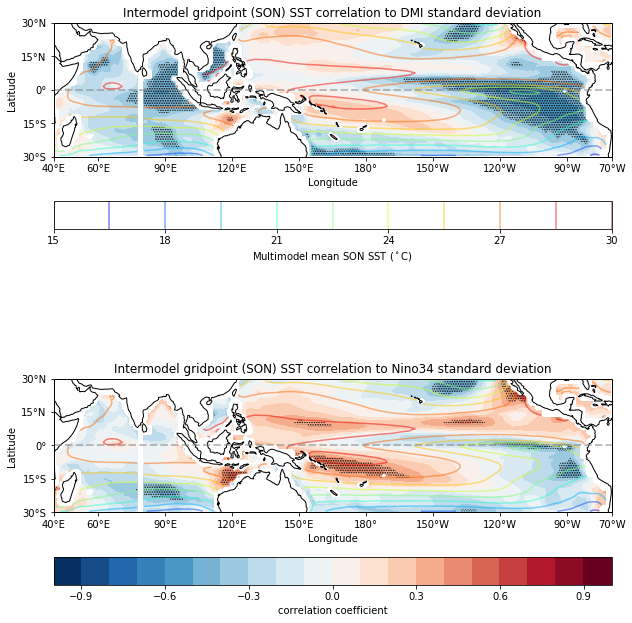

In [6]:
#now plot the result with significant areas
fig=plt.figure(figsize=(10,12))
ax1 =fig.add_subplot(2,1,1, projection=ccrs.PlateCarree(central_longitude=130.0))
ax1.coastlines()
cD_xr.plot.contourf(ax=ax1, transform=ccrs.PlateCarree(),cmap='RdBu_r', vmin=-1, vmax=1, levels=21, antialiasing=True, add_colorbar=False)
pD_sig.plot.contourf(ax=ax1, transform=ccrs.PlateCarree(), colors='none', hatches=['.....'], add_colorbar=False)
fill=sst_c.where(sst_c>=cD_xr, drop=False).mean('time').plot.contour(ax=ax1, transform=ccrs.PlateCarree(), levels=10, alpha=0.5, cmap='jet')
cb = plt.colorbar(fill, orientation='horizontal')
cb.set_label('Multimodel mean SON SST ($^\circ$C)')
ax1.set_title('Intermodel gridpoint (SON) SST correlation to DMI standard deviation')

ax2 =fig.add_subplot(2,1,2, projection=ccrs.PlateCarree(central_longitude=130.0))
ax2.coastlines()
fill=cN_xr.plot.contourf(ax=ax2, transform=ccrs.PlateCarree(),cmap='RdBu_r', vmin=-1, vmax=1, levels=21, antialiasing=True, add_colorbar=False)
cb = plt.colorbar(fill, orientation='horizontal')
cb.set_label('correlation coefficient')
pN_sig.plot.contourf(ax=ax2, transform=ccrs.PlateCarree(), colors='none', hatches=['.....'], add_colorbar=False)
sst_c.where(sst_c>=cD_xr, drop=False).mean('time').plot.contour(ax=ax2, transform=ccrs.PlateCarree(), levels=10, alpha=0.5, cmap='jet')
ax2.set_title('Intermodel gridpoint (SON) SST correlation to Nino34 standard deviation')
#add in lat lon
ax1.set_xlim(-90, 160)
ax1.set_ylim(-30,30)
ax2.set_xlim(-90, 160)
ax2.set_ylim(-30,30)
ax2.set_xticks([40, 60, 90,120, 150, 180, 210, 240, 270, 290], crs=ccrs.PlateCarree())
ax2.set_yticks([-30, -15, 0, 15, 30], crs=ccrs.PlateCarree())
ax1.set_xticks([40, 60, 90,120, 150, 180, 210, 240, 270, 290], crs=ccrs.PlateCarree())
ax1.set_yticks([-30, -15, 0, 15, 30], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)
ax2.set_xlabel("Longitude")
ax2.set_ylabel("Latitude")
ax1.gridlines(ylocs=[0], linewidth=2, color='gray', alpha=0.5, linestyle='--')
ax2.gridlines(ylocs=[0], linewidth=2, color='gray', alpha=0.5, linestyle='--')


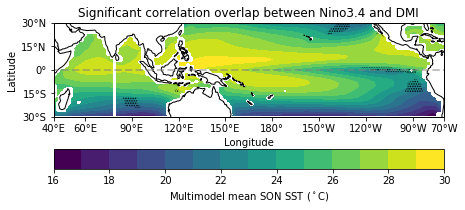

In [7]:
#looking at region of similarity
p_all=pD_sig.where(pN_sig<=pN_sig, drop=True)

#also cal multimodel SON sst mean
#get rid of land values for sst
sst_c=sst_.where(sst_>0, drop=False)
SON_SST_MMM=sst_c.mean('time')



fig=plt.figure(figsize=(7,4))
ax1 =fig.add_subplot(1,1,1, projection=ccrs.PlateCarree(central_longitude=130.0))
ax1.coastlines()
fill=sst_c.where(sst_c>=cD_xr, drop=False).mean('time').plot.contourf(ax=ax1, transform=ccrs.PlateCarree(), levels=15, add_colorbar=False)
p_all.plot.contourf(ax=ax1, transform=ccrs.PlateCarree(),colors='none', hatches=['.....'], add_colorbar=False)
ax1.set_xlim(-90, 160)
ax1.set_ylim(-30,30)
cb = plt.colorbar(fill, orientation='horizontal')
cb.set_label('Multimodel mean SON SST ($^\circ$C)')
plt.title('Significant correlation overlap between Nino3.4 and DMI')
ax1.set_xticks([40, 60, 90,120, 150, 180, 210, 240, 270, 290], crs=ccrs.PlateCarree())
ax1.set_yticks([-30, -15, 0, 15, 30], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")
ax1.gridlines(ylocs=[0], linewidth=2, color='gray', alpha=0.5, linestyle='--')

In [8]:
"""this region of shared significance in the pacific ocean is likely a cold tongue bias impacting on the IOD.
Models with cooler SST in this region tend to have stonger IODs. This can be tested with a scatter plot and
correlation analysis
Define this region as 120-90W, +-5N S
Now make function that gets this rewgion sst in SON for each model, and the IOD and ENSO strength to see if there 
is a robust relationship"""
def STD_SST(DS):
    sst=xr.open_dataset(DS).tos
    if sst.mean() > 100:
        sst = sst-273.15
#        sst=sst.where(sst > 270, drop = True)
#    else:
#         sst=sst.where(sst>-1, drop = True)   
    sst=sst.assign_coords(lon=(sst.lon % 360)).roll(lon=180, roll_coords=True)#get so 180 is central longitude
    sst = sst.sel(lat=slice(-30,30),lon=slice(40,290))
    climatology_mean=sst.groupby('time.month').mean('time')
    ssta=sst.groupby('time.month')-climatology_mean
    #detrend data with globally averaged sst
    sstade=ssta.rolling(time=264,center=True)
    sstade_TS=sstade.mean()#this timeseries is detreneded at every point individually
    # remove years with nan
    sstade_nan=sstade_TS.dropna('time',how='all')#this gets rid of all the years with nan ie the years consumed in the rolling average
    ssta=ssta-sstade_nan
    WTIO=ssta.sel(lat=slice(-10,10),lon=slice(50,70)).mean(['lat','lon'])
    SETIO=ssta.sel(lat=slice(-10,0),lon=slice(90,110)).mean(['lat','lon'])
    DMI=WTIO-SETIO
    #bias
    bias = sst.sel(lat=slice(-5,5),lon=slice(240,270)).mean(['lat','lon'])
    ctb = bias.sel(time=bias['time.season']=='SON').mean('time')  
    std=DMI.std()
    Nino34=ssta.sel(lat=slice(-5,5),lon=slice(190,240)).mean(['lat','lon'])
    Nstd =  Nino34.std()
    return (ctb, std, Nstd)

In [9]:
#set up data for unique markers in plot
data=[]
pmkr=['o', '^', 'v', 'D', '*', 's', '<', '>','o', '^', 'v', 'D', '*', 's', '<', '>','o', '^', 'v', 'D', '*', 's', '<', '>','o', '^', 'v', 'D', '*', 's', '<', '>']
col = ['b', 'g', 'r','c', 'y', 'm','b', 'g', 'r','c', 'y', 'm','b', 'g', 'r','c', 'y', 'm','b', 'g', 'r','c', 'y', 'm','g', 'r','c', 'y', 'm','b', 'g', 'r']
for i, file in enumerate(files):
    name = file[15:][:-7]
    if name == file[15:][:-7]:
        pm = pmkr[i]
        cl = col[i]
    data.append([file, name, pm, cl])

/home/z5113258/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/z5113258/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/z5113258/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/z5113258/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/z5113258/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/z5113258/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/z5113258/anacond

-0.5775992848344321 0.0005370205892249172
-0.29392737862339485 0.10250060146916029


Text(25, 1.35, 'P value =0.1025')

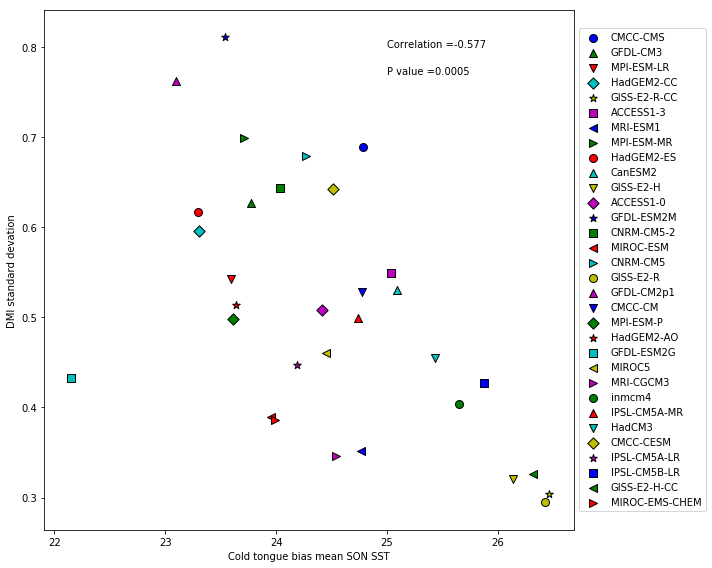

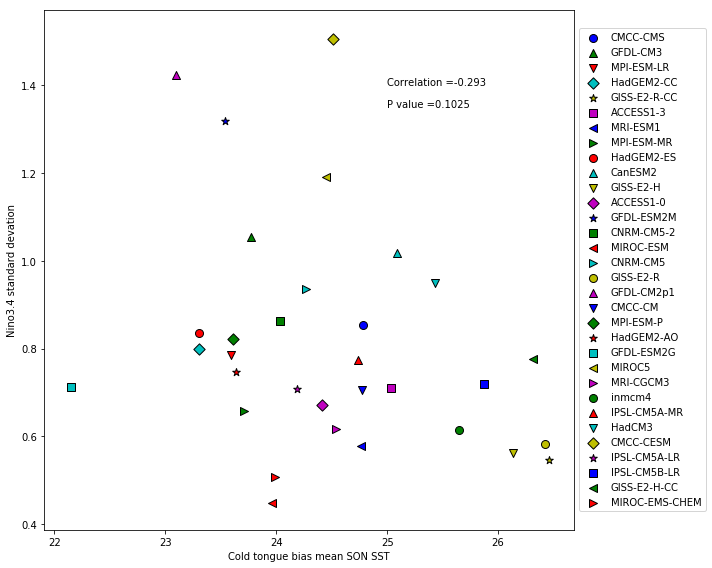

In [10]:
file_data=[]
for stuff in data:
    file, name, pm, cl = stuff
    ctb, dmi, nino = STD_SST(file)
    file_data.append([name, pm, cl, ctb, dmi, nino])
#now new loop to plot for the DMI vs CTB strength
DMI=[]
CTB=[]
NINO=[]
for data in file_data:
    plt.figure(1, figsize=(10,8))
    name, pm, cl, ctb, dmi, nino = data
    DMI.append(dmi)
    CTB.append(ctb)
    NINO.append(nino)
    plt.scatter(ctb, dmi, marker = pm, c=cl, label = name, edgecolors = 'k', s=2**6 )
    plt.xlabel("Cold tongue bias mean SON SST")
    plt.ylabel("DMI standard devation")
    plt.legend(loc = 'center left', bbox_to_anchor=(1,0.5))
    plt.tight_layout()
    plt.figure(2, figsize = (10,8))
    plt.scatter(ctb, nino, marker = pm, c=cl, label = name, edgecolors = 'k', s=2**6 )
    plt.xlabel("Cold tongue bias mean SON SST")
    plt.ylabel("Nino3.4 standard devation")
    plt.legend(loc = 'center left', bbox_to_anchor=(1,0.5))
    plt.tight_layout()
#calc correlation coefficient an pvals
CD, PD = pearsonr(CTB, DMI)
CN, PN = pearsonr(CTB, NINO)
print (CD, PD)
print (CN, PN)
plt.figure(1)
plt.text(25,0.8, "Correlation =" + str(CD)[:6])
plt.text(25,0.77 , "P value =" +str(PD)[:6])
plt.figure(2)
plt.text(25,1.4, "Correlation =" + str(CN)[:6])
plt.text(25,1.35 , "P value =" +str(PN)[:6])